In [15]:
import os, re 
import numpy as np
import tensorflow as tf
import glob
import tensorflow

In [19]:
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path) 
raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담기
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() #read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['', '', '[Spoken Intro:]']


In [17]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지운다
#     2. 특수문자 양쪽에 공백을 넣는다
#     3. 여러개의 공백은 하나의 공백으로 바꾼다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾼다
#     5. 다시 양쪽 공백을 지운다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가한다

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 필터링되는지 확인
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [18]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx >15: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

[Spoken Intro:]
You ever want something 
that you know you shouldn't have 
The more you know you shouldn't have it, 
The more you want it 
And then one day you get it, 
It's so good too 
But it's just like my girl 
When she's around me 
I just feel so good, so good 
But right now I just feel cold, so cold 
Right down to my bones 
'Cause ooh... 
Ain't no sunshine when she's gone 


In [7]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    tensor = tokenizer.texts_to_sequences(corpus)   
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=20)  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2 2701 2584 ...    0    0    0]
 [   2    7  156 ...    0    0    0]
 [   2   17    7 ...    0    0    0]
 ...
 [   2  311    1 ...    0    0    0]
 [   2  735    5 ...    0    0    0]
 [   2  735    5 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f9114e95910>


In [10]:
# tokenizer.index_word: 현재 계산된 단어의 인덱스와 인덱스에 해당하는 단어를 dictionary 형대로 반환 (Ex. {index: '~~', index: '~~', ...})
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [12]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[   2 2701 2584    3    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
[2701 2584    3    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]


In [21]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=34)

In [22]:
print('Source Train: ', enc_train.shape)
print('Target Train: ', dec_train.shape)

Source Train:  (140599, 19)
Target Train:  (140599, 19)


In [23]:
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [25]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = Embedding(vocab_size, embedding_size)
        self.rnn_1 = LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = LSTM(hidden_size, return_sequences=True)
        self.linear = Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 19
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [26]:
history = []
epochs = 10

optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)

history = model.fit(enc_train, 
          dec_train, 
          epochs=epochs,
          batch_size=256,
          validation_data=(enc_val, dec_val),
          verbose=1)

Epoch 1/10
550/550 [==============================] - 327s 558ms/step - loss: 3.1146 - val_loss: 2.7545
Epoch 2/10
550/550 [==============================] - 311s 565ms/step - loss: 2.6562 - val_loss: 2.5972
Epoch 3/10
550/550 [==============================] - 312s 567ms/step - loss: 2.5294 - val_loss: 2.5015
Epoch 4/10
550/550 [==============================] - 312s 568ms/step - loss: 2.4452 - val_loss: 2.4435
Epoch 5/10
550/550 [==============================] - 313s 570ms/step - loss: 2.3701 - val_loss: 2.3662
Epoch 6/10
550/550 [==============================] - 314s 570ms/step - loss: 2.2822 - val_loss: 2.3019
Epoch 7/10
550/550 [==============================] - 314s 571ms/step - loss: 2.2044 - val_loss: 2.2477
Epoch 8/10
550/550 [==============================] - 314s 572ms/step - loss: 2.1279 - val_loss: 2.1975
Epoch 9/10
550/550 [==============================] - 315s 572ms/step - loss: 2.0541 - val_loss: 2.1568
Epoch 10/10
550/550 [==============================] - 314s 571m

In [13]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
 # tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
 # tokenize() 함수에서 num_words를 7000개로 선언했기 때문에, tokenizer.num_words의 값은 7000
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 19), (256, 19)), types: (tf.int32, tf.int32)>

In [27]:
import matplotlib.pyplot as plt

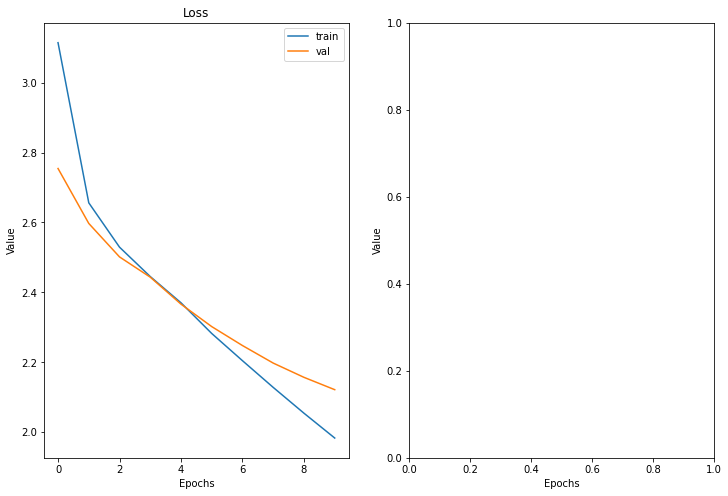

In [28]:
 plot_curve(history.epoch, history.history, ['loss', 'val_loss'])

In [33]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <END>를 예측하지 않았거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

In [34]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you so much , i love you so much , i love you so much <end> '